<a href="https://colab.research.google.com/github/Taedriel/ZSL-v2/blob/googleImageFSL/pipeline_22_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#---INSTALL---

In [ ]:
!yes | pip install -U --quiet selenium scikit-learn-intelex Pillow sklearn
!cd "./drive/MyDrive/Colab Notebooks/pipeline" && pip install -r --quiet requirements.txt

!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

     |████████████████████████████████| 981 kB 5.2 MB/s 
     |████████████████████████████████| 87 kB 9.1 MB/s 
     |████████████████████████████████| 3.1 MB 57.4 MB/s 
     |████████████████████████████████| 358 kB 67.1 MB/s 
     |████████████████████████████████| 139 kB 77.0 MB/s 
     |████████████████████████████████| 4.1 MB 39.4 MB/s 
     |████████████████████████████████| 55 kB 5.2 MB/s 
     |████████████████████████████████| 58 kB 7.7 MB/s 
     |████████████████████████████████| 26.0 MB 1.2 MB/s 
     |████████████████████████████████| 300.3 MB 19 kB/s 
     |████████████████████████████████| 4.0 MB 38.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.11 which is incompatible.
ERROR: Could not open requirements file: [Errno 2] No such file or directory

#--- CONSTANT DEFINITION AND IMPORT ---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from statistics import mean, pstdev

import os, itertools, shutil, time, random, re, math
import PIL.Image

from IPython.core.display import Image

import requests, webbrowser, urllib.request
from selenium import webdriver
from bs4 import BeautifulSoup 

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torchvision.models import resnet18, resnet50
from sklearn.metrics import classification_report, confusion_matrix
from scipy import ndimage, misc, stats

from tqdm import tqdm
from pathlib import Path

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/pipeline/"
PATH_IMAGES = "/content/drive/MyDrive/Colab Notebooks/pipeline/images/"
PATH_MODEL = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/"

globalSize = 20
LEN_FOR_ONE_SCROLL = 20

N_WAY = 5
N_SHOT = 5
N_QUERY = 15

batchSize = 125

showDataClean, showDataTrain = True, False

#--- UTILS ---

In [ ]:
"""
@desc get set of all classes to be used for cleaning from a text file

@param classesFile the path to the file
@param searchPrecision additional keywords

@return the list of all classes without spaces between keywords
"""
def createListOfClasses(classesFile, searchPrecision=""):

  classes = []
  index=0

  for animal in classesFile.readlines():
    animal = animal.strip("\n").replace(" ", "")
    classes.append(animal + searchPrecision)

  return classes

In [ ]:
"""
@desc get mean and incertitude from a list of mesurements

@param mesurements list of experiments, the title of the experiement is the first element.
@param k the student number

@return the string representing the mean and uncertainty of the experiments
"""
def getUa(mesurements, k=1):

  title = mesurements[0]
  l = mesurements[1:]
  inv_n = 1.0/(len(l)-1)
  inv_ns = 1.0/pow(len(l), 0.5)
  m_ = round(mean(l), 2)
  dm2 = [pow(mi - m_, 2) for mi in l]
  pstd = pow(inv_n*sum(dm2), 0.5)
  u = round(k*pstd*inv_ns, 2)
  
  return title+str(m_) + "% +- " + str(u) + " (with 95% confidence)" if k!=1 else "", m_, u

def getUaList(listOfExperiences, k=1):

  for mesurements in listOfExperiences:
    string, m_, u = getUa(mesurements, k)
    print(string)

In [ ]:
"""
@desc remove the label from each tuple (I, label) in a set of images (used for display)

@param set_ the set of images to remove the labels from

@return the set without label
"""
def getOnlyImages(set_):
  
  justSet = []
  for class_ in set_:
    for image in class_:
      justSet.append(image[0])

  return torch.stack(justSet)

def plot_images(images, title, images_per_row):
  plt.figure()
  plt.title(title)
  plt.imshow(utils.make_grid(images, nrow=images_per_row).permute(1, 2, 0))

In [ ]:
def saveFile(filename, data):
  file = open(PATH_MODEL+filename, "w+")
  for d in data:
    file.write(str(d)+"\n")
  file.close()

def showRegression(rangeOfData, data, degree):
  coef = np.polyfit(rangeOfData, data, degree)
  poly1d_fn = np.poly1d(coef) 
  plt.plot(rangeOfData, data, '-yo', rangeOfData, poly1d_fn(rangeOfData), '--k')
  plt.show()
  print("regression polynome :\n")
  print(np.poly1d(poly1d_fn))
  print("started at", data[0], "and ended at", data[-1])
  print("\n")

def showData(data, title, degree, saveInfo=[False, ""]):

  path = saveInfo[1]
  if saveInfo[0]:
    saveFile(path, data)

  numberOfIteration = range(0, len(data))

  plt.plot(numberOfIteration, data)
  plt.title(title)
  plt.show()
  showRegression(numberOfIteration, data, degree)

In [ ]:
"""
@desc get the confusion matrix and additional information based on the result of 
the model test.

@param labels a list of number representing each class
@param predicted_labels a list of predicted class by the model

@return accuracy, confusion matrix and other details (see scipy)
"""
def getMatrixReport(labels, predicted_labels):
    print("\n")
    listOfClasses = list(dict.fromkeys(labels))
    res = classification_report(labels, predicted_labels, target_names=["c"+str(i) for i in range(1, len(listOfClasses)+1)],  output_dict=True)
    return res, res['accuracy'], confusion_matrix(labels, predicted_labels)

In [ ]:
"""
@desc verify if the numbers are in a specific range

@param interval a list of number to check
@param range_ the specific range 

@return the number of number in the specified range
"""
def numberInInterval(interval, range_):
  in_ = 0
  minX = range_[0]
  maxX = range_[1]
  for x in interval:
    if x >= minX and x < maxX:
      in_+=1
    
    if x == 1 and maxX == 1:
      in_+=1

  return in_

def getDistributionOnPred(correctPredictions, bins):
  NumberDist = []
  for elem in bins:
    NumberDist.append(100*numberInInterval(correctPredictions, elem)/len(correctPredictions))

  return NumberDist

def createHistogramPreds(predictions, title):

  bins = [(i*0.1, (i+1)*0.1) for i in range(0, 10)]
  NumberDist = getDistributionOnPred(predictions, bins)

  fig, ax = plt.subplots()
  for i, percentage in enumerate(NumberDist):
    ax.add_patch(Rectangle((0.1*i, 0), 0.1, percentage, edgecolor='black'))
  plt.ylim(int(max(NumberDist))+2)
  plt.gca().invert_yaxis()
  plt.xlabel(title)
  plt.ylabel("number of predictions in %")
  plt.show()

  return NumberDist

In [ ]:
"""
@desc separate the original distribution into two based on a value

@param dist the distribution to split in half
@param threshold the value that represent the split

@return two new distributions
"""
def getSimilarityDistributions(dist, threshold):
  dist1 = []
  dist2 = []

  for x in dist:
    if x > threshold:
      dist2.append(x)
    else:
      dist1.append(x)

  return dist1, dist2


"""
@desc get the r parameter used to discriminate between good and bad images during cleaning

@param dist1 the lower distribution (from getSimilarityDistributions)
@param dist2 the higher distribution(ibid.) 

@return the r parameter of an image
"""
def getR(dist1, dist2):

  L1, L2 = len(dist1), len(dist2)
  return L2/L1 if L1 != 0 else -1

def printDistributions(dist, threshold):

  dist1, dist2 = getSimilarityDistributions(dist, threshold)
  L1, L2 = len(dist1), len(dist2)
  r = getR(dist1, dist2)
  
  print("r (L2/L1) = ", r if r >= 0 else "+inf")
  plt.hist(dist1,bins=10)
  plt.hist(dist2,bins=10)
  plt.xlabel("similarity to the query")
  plt.ylabel("number of images")
  plt.show()

In [ ]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

#--- IMAGE RETRIEVAL FUNCTIONS ---

In [ ]:
"""
thumbnail / jpg (compression) may be an issue
"""

def getParser(classeName):

  site = 'https://www.google.com/search?tbm=isch&q='+classeName

  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')

  driver = webdriver.Chrome('chromedriver', options=chrome_options)
  driver.get(site)
  driver.execute_script("window.scrollBy(0, document.body.scrollHeight)")
  soup = BeautifulSoup(driver.page_source, 'html.parser')
  driver.close()

  return soup

In [ ]:
"""
@desc retrieve 20 images for a specific class

@param path path to the folder that will contain the images
@param classeName name of the class 

@return the number of downloaded images
"""
def getClassImages(path, classeName):
  
  imagesNumber = 0
  soup = getParser(classeName)
  img_tags = soup.find_all("img", class_="rg_i")

  for index in range(0, len(img_tags)):
    try:
        urllib.request.urlretrieve(img_tags[index]['src'], path+classeName+"/"+str(classeName+str(index))+".jpg")
        imagesNumber+=1
    except Exception as e:
        pass

  return imagesNumber

def getImagesGoogle(classes):

  imagesNumber = 0
  shutil.rmtree(PATH_IMAGES, ignore_errors=False)
  os.makedirs(PATH_IMAGES)

  print("downloading images...")

  for classe in tqdm(classes):

    try:
      classeName = classe.replace(" ", "")
      os.makedirs(PATH_IMAGES+classeName)
      imagesNumber += getClassImages(PATH_IMAGES, classeName)
    except:
      pass

  return imagesNumber

In [ ]:
def getClassesImagesURLLIB(classes, download=True):

  imagesNumber = 0

  if download:
    imagesNumber = getImagesGoogle(classes)
  
  print("\n"+str(imagesNumber) + " images were downloaded. " + str(imagesNumber/len(classes)) + " per classes")

#--- DATASET ---

##--- Base functions ---

In [ ]:
def getNrandomClassesPaths(path, listClasses, n_way):

  if n_way == len(listClasses):
    return listClasses

  paths = []
  for i in range(0, n_way):
    ridx = random.randint(0, len(listClasses)-1)
    paths.append(path+listClasses[ridx]+"/")
    listClasses.remove(listClasses[ridx])

  return paths

In [ ]:
imageResize = (224, 224)

def getImageTensor(path):
  convertCUBLike = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0, 0, 0), (1, 1, 1))
                              ])
  convertOmni = transforms.Compose([
                              transforms.Grayscale(num_output_channels=3),
                              transforms.ToTensor(),
                              transforms.Normalize((0, 0, 0), (1, 1, 1))
                            ])

  return convertCUBLike(PIL.Image.open(path).resize(imageResize))

##--- For cleaning ---

In [ ]:

"""
@desc The MetaSet class implement a way to handle images during the cleaning
process. It does so by constructing a set of matrices, each representing one aspect of the data
"""
class MetaSet:

  def __init__(self):
    """
    the lenght parameter is here in order to avoid testing the query against
    unrelated images
    """
    self.supportSetMatrix = []
    self.querySetMatrix = []
    self.supportLenghtMatrix = []
    self.imageNameSetMatrix = []
    self.buffer = [[], [], []]


  def __call__(self, i, j):
    return (self.supportSetMatrix[i][j], self.querySetMatrix[i][j], 
            self.supportLenghtMatrix[i][j])


  def lenght(self):
    rows = len(self.supportSetMatrix)
    columns = len(self.supportSetMatrix[0]) if self.supportSetMatrix != [] else 0 

    return rows, columns


  def clearBuffer(self):
    self.buffer = [[], [], []]


  """
  @desc add values to the buffer to be put into the matrices later

  @param arrayOfValues must have the form [support set Images, Query set images, lenght of support set]
  """
  def addToBuffer(self, arrayOfValue):
    for index in range(0, 3):
      self.buffer[index].append(arrayOfValue[index])


  """
  @desc add the values present in the buffer to each matrix and then clear the buffer
  """
  def setLine(self):
    self.supportSetMatrix.append(self.buffer[0])
    self.querySetMatrix.append(self.buffer[1])
    self.supportLenghtMatrix.append(self.buffer[2])
    self.clearBuffer()

In [ ]:
"""
@desc Class implementing the data structure creation for the cleaning part 
of the pipeline. 
Among other thing this class add negative examples to the support set after extracting the query
"""
class CleaningSetProvider:

  def __init__(self, pathToImage, numberOfPositives, numberOfNegatives):
    self.pathToNegatives = "/content/drive/MyDrive/Colab Notebooks/pipeline/ImageNetFetched/"
    self.path = pathToImage
    self.nbNegative = numberOfNegatives
    self.nbPositive = numberOfPositives


  def getSubSetOfImages(self, path):
    images = os.listdir(path)
    images.sort(key=natural_keys)
    images = images[0:self.nbPositive]

    return images


  def addNegativeExamples(self, pathToClass, label, supportSet):

    images = os.listdir(pathToClass)
    for i in range(0, self.nbNegative):
      supportSet.append((getImageTensor(pathToClass+images[i]), label))

    return supportSet


  def addNegativeClasses(self, supportSet):

    negativeClasses = os.listdir(self.pathToNegatives)
    for i in range(0, len(negativeClasses)):
      supportSet = self.addNegativeExamples(self.pathToNegatives+negativeClasses[i]+"/", i+1, supportSet)

    return supportSet


  """
  @desc construct one element to be put into the metaSet.
  
  @param pathToClass the path to the class images
  @param label the label of the class
  @param q_index the index of the query image in the folder

  @return the corresponding support and query set + the original lenght of the support set
  """
  def getFolderTensorsForCleaning(self, pathToClass, label, q_index):

    images = self.getSubSetOfImages(pathToClass)
    originalLenght = len(images)

    query = (getImageTensor(pathToClass+images[q_index]), label)
    images.remove(images[q_index])

    support = []
    for image in images:
      support.append((getImageTensor(pathToClass+image), label))
    
    support = self.addNegativeClasses(support)

    return [support, query, originalLenght]


  def getSetOfCleaningSets(self, listClasses):

    meta_set = MetaSet()
    for class_ in listClasses:

      listEx = self.getSubSetOfImages(self.path+class_)
      for q_index in range(0, len(listEx)):
        oneElement = self.getFolderTensorsForCleaning(self.path+class_+"/", 0, q_index)
        meta_set.addToBuffer(oneElement)

      meta_set.setLine()
      meta_set.imageNameSetMatrix.append([self.path+class_+"/"+image for image in listEx])

    return meta_set

##--- For training in FSL ---

In [ ]:
# each set is as follows : 
"""
[
  [(I, c), (I, c), ..., (I, c), (I, c)],
  [(I, c), (I, c), ..., (I, c), (I, c)],
   .          .                    .
   .            .                  .
   .              .                .
   .                .              .
                      .            .
  [(I, c), (I, c), ..., (I, c), (I, c)]
]
"""
 

def getFolderTensorsForTraining(path, supportNumber, queryNumber, label):

  images = os.listdir(path)
  images.sort(key=natural_keys)
  support_i, query_i = [], []

  for i in range(0, supportNumber):
    ridx = random.randint(0, len(images)-1)
    support_i.append( (getImageTensor(path+images[ridx]), label) )
    images.remove(images[ridx])
  
  for i in range(0, queryNumber):
    ridx = random.randint(0, len(images)-1)
    try:
      query_i.append( (getImageTensor(path+images[ridx]), label) )
    except:
      pass
    images.remove(images[ridx])

  return support_i, query_i


"""
@desc get the support set and query set for training the model after cleaning

@param supportNumber the n_shot parameter 
@param queryNumber the number of query

@return the support and query set
"""
def getSets(paths, supportNumber, queryNumber):

  supportSet, querySet = [], []
  for label, path in enumerate(paths):
    Si, Qi = getFolderTensorsForTraining(path, supportNumber, queryNumber, label)
    supportSet.append(Si)
    querySet.append(Qi)

  return supportSet, querySet

##--- PAIR GENERATION ---

In [ ]:
def getIndexes(setOfImages, nbClasses, cleaning=False):

  nbEx =  len(setOfImages) if cleaning else len(setOfImages[0])
  ci1, e1 = random.randint(0, nbClasses-1), random.randint(0, nbEx-1) 
  ci2, e2 = random.randint(0, nbClasses-1), random.randint(0, nbEx-1)

  return ci1, ci2, e1, e2


"""
the cleaning parameter is here because cleaning data and training data have
different shapes
"""
def getRandomPair(setOfImages, cleaning=False):

  nbClasses = len(setOfImages)
  ci1, ci2, e1, e2 = getIndexes(setOfImages, nbClasses, cleaning)
  
  I1, I2, s = 0, 0, 0
  if cleaning:
      c1, c2 = setOfImages[e1][1], setOfImages[e2][1]
      I1, I2 = torch.stack([setOfImages[e1][0]]), torch.stack([setOfImages[e2][0]])
      s = 1.0 if c1 == c2 else 0.0
  else:
    I1, I2 = torch.stack([setOfImages[ci1][e1][0]]), torch.stack([setOfImages[ci2][e2][0]])
    s = 1.0 if ci1 == ci2 else 0.0

  return I1, I2, s

#--- NETWORK ---

## --- Utils ---

In [ ]:
class ModelUtils:

  def __init__(self):
    pass

  def getOptimizer(self, model):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    return optimizer
  
  def getImages(self, image1, image2):

    if image1.dim() < 4:
      image1 = image1.unsqueeze(0)
    
    if image2.dim() < 4:
      image2 = image2.unsqueeze(0)

    return image1, image2

  def resetModelParam(self, model):

    for layer in model.children():
      if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

    return model

In [ ]:
class ModelSaver:

  def __init__(self, path):
    self.PATH_MODEL = path

  def saveModel(self, name, model_opti, epoch, loss_value):

    model, optimizer = model_opti[0], model_opti[1]

    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_value
    }, self.PATH_MODEL+name)

  def loadModel(self, model_name, model, optimizer):
    
    checkpoint = torch.load(self.PATH_MODEL+model_name)
    model.load_state_dict(checkpoint['model_state_dict'])  
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_ = checkpoint['epoch']
    loss_ = checkpoint['loss']

    return (epoch_, loss_), model, optimizer

##--- Models ---

In [ ]:
cuda_ = True
enter = 2048
hidden = 2000

metricCleaning = nn.Sequential(nn.Linear(enter, hidden), nn.ReLU(),
                               
                               nn.Linear(hidden, hidden), nn.ReLU(),
                               nn.Linear(hidden, hidden), nn.ReLU(),
                               nn.Linear(hidden, hidden), nn.ReLU(),
                               nn.Linear(hidden, hidden), nn.ReLU(),
                               nn.Linear(hidden, hidden), nn.ReLU(),
                               nn.Linear(hidden, hidden), nn.ReLU(),

                               nn.Linear(hidden, 1)) 

metric = nn.Sequential(nn.Linear(enter, hidden), nn.ReLU(),
                       
                       nn.Linear(hidden, hidden), nn.ReLU(),
                       nn.Linear(hidden, hidden), nn.ReLU(),
                       nn.Linear(hidden, hidden), nn.ReLU(),
                       nn.Linear(hidden, hidden), nn.ReLU(),
                       nn.Linear(hidden, hidden), nn.ReLU(),
                       nn.Linear(hidden, hidden), nn.ReLU(),

                       nn.Linear(hidden, 1)) 

In [ ]:
class Siamese(nn.Module):

  """
  I1 --> CNN --> u
                  \
                    |u-v| --> NN --> x --> s(x) --> L(.,.)
                  /
  I2 --> CNN --> v
  """

  def __init__(self, modules, metric, cuda_):
    super(Siamese, self).__init__()
    
    self.cuda_ = cuda_
    self.backbone = nn.Sequential(*modules).cuda() if cuda_ else nn.Sequential(*modules)
    self.metric = metric.cuda() if cuda_ else metric
    self.combination = lambda u, v: torch.abs(u-v)      

  def get_vector(self, image):
    image = image.cuda() if self.cuda_ else image
    return torch.flatten(self.backbone(image))

  def createCombinedVector(self, I1, I2):
    u = self.get_vector(I1)
    v = self.get_vector(I2)
    return self.combination(u, v), u, v 

  def forward(self, w):
    out = self.metric(w)
    out_normalized = torch.sigmoid(out)

    return out_normalized

In [ ]:
backbone = resnet50(weights="IMAGENET1K_V2")
modules=list(backbone.children())[:-1]

if cuda_:
  modelCleaning = Siamese(modules, metricCleaning, cuda_).cuda()
  model = Siamese(modules, metric, cuda_).cuda()

else:
  modelCleaning = Siamese(modules, metricCleaning, cuda_)
  model = Siamese(modules, metric, cuda_)

#--- TRAINING CLASS ---

In [ ]:
"""
@desc Class implementing the training of the model after the cleaning process
"""
class Trainer(ModelUtils):

  def __init__(self, path_model, model, cleaning):

    super().__init__()
    self.cleaningPhase = cleaning
    self.model = model
    self.optimizer = super().getOptimizer(self.model.metric)
    self.LOSS = nn.BCELoss()

    self.model_saver = ModelSaver(path_model)


  def resetModel(self, reset_by_param=False):
    if not reset_by_param:
      _, model, opti = self.model_saver.loadModel("SN6L2k_.pt", self.model.metric, self.optimizer)
      self.model.metric, self.optimizer = model, opti
    else:
      self.model.metric = super().resetModelParam(self.model.metric)
      self.optimizer = super().getOptimizer(self.model.metric)


  def epoch(self, suppSet):

    lossForBatch = []
    for i in range(0, batchSize):

      I1, I2, s = getRandomPair(suppSet, self.cleaningPhase)
      I1, I2 = super().getImages(I1, I2)
      w, u, v = self.model.createCombinedVector(I1, I2)
      out = self.model(w)
      s = torch.tensor([s]).cuda() if cuda_ else torch.tensor([s])

      self.optimizer.zero_grad()
      loss = self.LOSS(out, s)
      loss.backward()
      self.optimizer.step()
      lossForBatch.append(loss.item())

    return lossForBatch


  """
  @desc training of the model
  
  @param supportSet the set of images as created by getSets
  @param epoch_loss used if the training is to resumed
  @param set_i used for tqdm (show on which class we are training)
  
  @return losses a list of the mean loss per epoch
  """
  def training(self, supportSet, epoch_loss=(0, 0), set_i=0):

    numberOfEpochs = 300-epoch_loss[0]
    valFreq = 10

    losses = [epoch_loss[1]] if epoch_loss[1] != 0 else []
    
    self.model.train()
    for epoch_i in tqdm(range(0, numberOfEpochs), desc="Traning on Set "+str(set_i)):

      batchLoss = self.epoch(supportSet)
      mean_loss = sum(batchLoss)*1.0/len(batchLoss)
      losses.append(mean_loss)

      if epoch_i % valFreq == 0 and epoch_i != 0:
        model_opti =  [self.model.metric, self.optimizer]
        self.model_saver.saveModel("SNTrain.pt", model_opti, epoch_i, mean_loss)

    torch.save(self.model.metric.state_dict(), PATH_MODEL+"SN.pt")

    return losses

#--- save base model ---

In [ ]:
saveBaseModel = False
if saveBaseModel:

  saver = ModelSaver(PATH_MODEL)
  #t = Trainer(PATH_MODEL, modelCleaning, False)
  t2 = Trainer(PATH, model, False)

  saver.saveModel("SN6L2k_.pt", [t2.model.metric, t2.optimizer], 0, 0)

#--- TESTING CLASS ---

In [ ]:
"""
@desc Class implementing the testing part of the pipeline after the cleaning process
"""
class Tester(ModelUtils):

  def __init__(self, model):
    super().__init__()
    self.model = model

  """
  @desc get the class that is the most represented in a list of predictions

  @param predictions a list of prediction with (pred, label) format

  @return the label of the most represented class
  """
  def getFirstClassBasedOnRepresentation(self, predictions):

    representation = [0]*N_WAY
    for pred in predictions:
      representation[pred[0]] += 1

    return representation.index(max(representation))


  def isModelCorrect(self, predictions, queryClass):

    pred_sorted = sorted(predictions, key=lambda tup: tup[-1], reverse=True)
    first_five = pred_sorted[0:5]

    predictedClassLabel = self.getFirstClassBasedOnRepresentation(first_five)
    similarity = int(queryClass == predictedClassLabel)
    predictionScore = first_five[0][1]

    return similarity, predictedClassLabel, predictionScore

  
  def model_prediction(self, queryInfo, imageInfo, triplets):

    image, imageClass = imageInfo
    query, queryClass = queryInfo

    query, image = super().getImages(query, image)
    w, u, v = self.model.createCombinedVector(query, image)
    p = self.model(w)
    triplets.append((imageClass, p))

    areReallySimilar, imageClass, prediction = self.isModelCorrect(triplets, queryClass)

    return triplets, areReallySimilar, imageClass, prediction


  def evaluateWithMetric(self, supportSet, querySet):

    triplets = []
    pred_labels = []
    query_labels = []
    correctPreds, incorrectPreds, indexIncorrectQuery = [], [], []
    correct = 0
    
    self.model.eval()
    with torch.no_grad():

      for indexQuery, queryInfo in enumerate(list(itertools.chain(*querySet))):

        _, queryClass = queryInfo
        for imageInfo in list(itertools.chain(*supportSet)):
          triplets, areReallySimilar, imageClass, prediction = self.model_prediction(queryInfo, imageInfo, triplets)
          
        if areReallySimilar == 1: 
          correct+=1
          correctPreds.append(prediction)
        else:
          incorrectPreds.append(prediction)
          indexIncorrectQuery.append(indexQuery)

        triplets = []
        pred_labels.append(imageClass)
        query_labels.append(queryClass)

    return "\n accuracy :"+str(100.0*correct/(N_WAY*N_QUERY)), pred_labels, query_labels, correctPreds, incorrectPreds, indexIncorrectQuery


  def queryEvaluation(self, supportSet, querySet):

    triplets = []
    self.model.eval()
    with torch.no_grad():

      query, queryClass = querySet
      for imageInfo in list(itertools.chain(*supportSet)):

        image, imageClass = imageInfo
        query, image = super().getImages(query, image)
        w = self.model.createCombinedVector(query, image)
        p = self.model(w)
        triplets.append((imageClass, p))
      
    pred_sorted = sorted(triplets, key=lambda tup: tup[-1], reverse=True)
    first_five = pred_sorted[0:5]
    predictedClassLabel = self.getFirstClassBasedOnRepresentation(first_five)

    return predictedClassLabel

#--- CLEANING CLASS --- 

In [ ]:
def printSimMatrix(M):
  for row in M:
    print(" ".join(list(map(lambda x: '{0: <8}'.format(x),row))), "\n")

def printPartSimMatrix(M, r):
  for row in M:
    print(" ".join(list(map(lambda x: str(x)+"\t",row[0:r]))), "\n")

"""
@desc class implementing the cleaning part of the pipeline
"""
class Cleaner(ModelUtils):

  def __init__(self, path_model, model, meta_set):
    super().__init__()

    self.meta_set = meta_set
    self.threshold = 0.5

    self.model_t = Trainer(path_model, model, True)
    self.model_saver = ModelSaver(path_model)

    self.falseVector = []
    self.trueVector = []


  def isQueryOutsider(self, Eij):

    model = self.model_t.model
    supportSet, querySet, lenght = Eij[0], Eij[1], Eij[2]-1
    preds = []

    model.eval()
    with torch.no_grad():

      query_raw = querySet[0]
      for image_raw, imageClass in supportSet[:lenght]:
        query, image = self.model_t.getImages(query_raw, image_raw)
        w = model.createCombinedVector(query, image)
        p = model(w)
        res = round(p.cpu().item(), 2)
        preds.append(res)
      
    return preds


  def getPredictionsForOneQuery(self, Eij, indexSet):

    _, model_, opti = self.model_saver.loadModel("SN6L2k_.pt", self.model_t.model.metric, self.model_t.optimizer)
    self.model_t.model.metric, self.model_t.optimizer = model_, opti
    
    self.model_t.training(Eij[0], set_i=indexSet) 
    preds = self.isQueryOutsider(Eij)

    return preds


  """
  @desc decide if the query is to be kept or not based on the r parameter

  @param indices the position of the image in the matrix
  @param Qij the query
  @param r its r parameter has calculated by getR()
  @param imageToClean a list of images

  @return the updated list of images to remove
  """
  def decideOnImageType(self, indices, Qij, r, imageToClean):

    tmp = imageToClean
    if 0 <= r < 1:
      self.falseVector.append(Qij)
      tmp.append(meta_set.imageNameSetMatrix[indices[0]][indices[1]]) 
    else:
      self.trueVector.append(Qij)

    return tmp


  def getTrueAndFalseVectors(self, index, threshold, simMatrix):

    rList = []
    pathToRemove = []
    for j in range(0, columns):
      Eij = [*meta_set(index, j)]
      distFalse, distTrue = getSimilarityDistributions(simMatrix[j], threshold)
      r = getR(distFalse, distTrue)
      rList.append(r)
      pathToRemove = self.decideOnImageType((index, j), Eij[1][0], r, pathToRemove)
    
    return pathToRemove, rList


  def showSeparation(self, rList):

    print(rList)
    if self.falseVector != []:
      falseTensor = torch.stack(self.falseVector)
      plot_images(falseTensor, "Images To Clean", images_per_row=len(self.falseVector))

    if self.trueVector != []:
      trueTensor = torch.stack(self.trueVector)
      plot_images(trueTensor, "Images to keep", images_per_row=len(self.trueVector))


  def cleanSets(self):
    
    rows, columns = self.meta_set.lenght()    
    for i in range(0, rows):

      simMatrix = []
      self.falseVector, self.trueVector = [], []
      for j in range(0, columns):

        Eij = [*self.meta_set(i, j)]
        preds = self.getPredictionsForOneQuery(Eij, i)
        simMatrix.append(preds[:j]+[1]+preds[j:])
        printSimMatrix(simMatrix)
     
      """
      flattenedMatrix = list(itertools.chain(*simMatrix))
      m, v = stats.norm.fit(flattenedMatrix)

      print("threshold is", m-v)
      pathToRemove, rList = self.getTrueAndFalseVectors(i, m-v, simMatrix)
      self.showSeparation(rList)
      """

      #clean
    return simMatrix

#--- PATH DEFINITION ---

In [ ]:
CUB, IMAGES, OMNIGLOT = False, True, False
PATH_DATA = ""
listClass = []

if CUB or IMAGES:
  PATH_DATA = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/data/CUB/images/" if CUB else "/content/drive/MyDrive/Colab Notebooks/pipeline/images/"
  listClass = os.listdir(PATH_DATA)
elif OMNIGLOT:
  PATH_DATA = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/dataO/omniglot-py/images_background/" 
  listAlphabet = os.listdir(PATH_DATA)
  choosenAlphabet = listAlphabet[random.randint(0, len(listAlphabet)-1)]
  listClass = [choosenAlphabet+"/"+char for char in os.listdir(PATH_DATA+choosenAlphabet)]

#--- TRAIN AND TEST ---

In [ ]:
supportClasses = getNrandomClassesPaths(PATH_DATA, listClass, N_WAY)

"""
['/content/drive/MyDrive/Colab Notebooks/pipeline/images/Americanrobinphotography/', 
                  '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Alligatorphotography/', 
                  '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Africanelephantphotography/', 
                  '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Amphibianphotography/', 
                  '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Anglerfishphotography/']
"""

print(supportClasses)
supportSet, querySet = getSets(supportClasses, N_SHOT, N_QUERY)

['/content/drive/MyDrive/Colab Notebooks/pipeline/images/Africanleopard/', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Ape/', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Angelfish/', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Africanelephant/', '/content/drive/MyDrive/Colab Notebooks/pipeline/images/Aphid/']


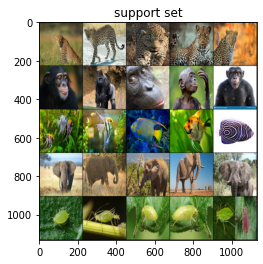

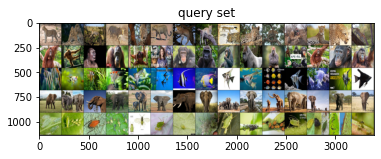

In [ ]:
justSupport = getOnlyImages(supportSet)
justQuery = getOnlyImages(querySet)
plot_images(justSupport, title="support set", images_per_row=N_SHOT)
plot_images(justQuery, title="query set", images_per_row=N_QUERY)

In [ ]:
training_model = Trainer(PATH_MODEL, model, False)

In [ ]:
#training_model.resetModel(reset_by_param=False)

trainingNeeded = True
if trainingNeeded:
  losses = training_model.training(supportSet, (0, 0), 0)

Traning on Set 0: 100%|██████████| 300/300 [34:57<00:00,  6.99s/it]


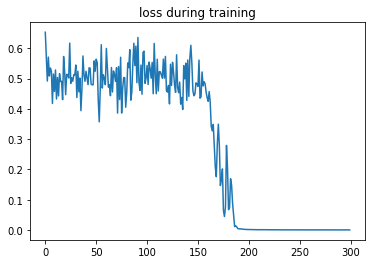

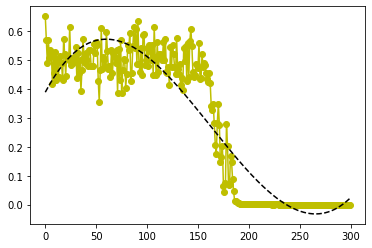

regression polynome :

           3             2
1.391e-07 x - 6.792e-05 x + 0.006635 x + 0.3896
started at 0.6528729219436645 and ended at 0.0001412535140809723




In [ ]:
showData(losses, "loss during training", 3)

In [ ]:
evaluation_model = Tester(training_model.model)
accuracyResults, y_pred, y, correctPreds, incorrectPreds, indexIncorrectQuery = evaluation_model.evaluateWithMetric(supportSet, querySet)

_, _, confM = getMatrixReport(y, y_pred)
print(accuracyResults)
print(confM)
print(indexIncorrectQuery)




 accuracy :68.0
[[13  0  2  0  0]
 [ 1  5  9  0  0]
 [ 2  0 13  0  0]
 [ 1  0  0 14  0]
 [ 1  0  8  0  6]]
[3, 10, 15, 16, 17, 18, 19, 21, 23, 25, 27, 29, 40, 41, 51, 60, 62, 63, 64, 67, 69, 70, 71, 73]


# --- STATS ---

In [ ]:
listOfExperiences5Old = [
                     ["(Adam, 1E-3), 3h1o (512, 240)..(240, 1)), Pre-done, 350x350, BCELoss, 70 epochs: ", 41, 40, 30.66, 34.66, 26.66],
                     ["(Adam, 1E-3), 3h1o (512, 240)..(240, 1)), Random  , 350x350, BCELoss, 70 epochs: ", 38.67, 26.67, 34.67, 38.67, 45],
                     ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, BCELoss, 70 epochs, normalized: ", 62.67, 50.67, 45.33, 54.67, 52],
                     ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, MSELoss, 70 epochs, normalized, representation, Omni ", 77.33, 77.33, 78.67, 77.33],
                     ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, MSELoss, 70 epochs, normalized, representation, Omni with reset ", 94.67, 86.67, 72],
                     ["(Adam, 1E-3), 3h1o (4096, 2048)..(2048, 1)) [use cat], Random, 224x224, BCELoss, 70 epochs, normalized, representation", 0, 0, 0, 0, 0]

                    ]
listOfExperiences6Old = [
                      ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, BCELoss, 70 epochs, normalized, representation: ", 60, 53.33, 72, 46.67, 53.33, 42.67],
                      ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 224x224, BCELoss, 70 epochs, normalized, representation, Omni: ", 84, 74.67, 92, 77.33, 76, 68]
                      ]

listOfExperiences7Old = [
                      ["(Adam, 1E-3), 3h1o (2048, 1024)..(1024, 1)), Random, 350x350, BCELoss, 70 epochs: ", 48, 46.67, 48, 41.33, 49, 42, 40]
                      ]

listOfExperiences6 = [
                      ["Google (SGD, 1E-3, 0.9), 2k4L, 100 epochs: ",62.67, 80, 58.67, 42.67, 50.67, 89.33],
                      ["Google (SGD, 1E-3, 0.9), 2k4L, 200 epochs: ",68, 72, 22, 69.33, 49],
                      ["Google (SGD, 1E-3, 0.9), 2k6L, 300 epochs: ",90.67, 90.67, 72, 68, 48, 78.67],
                      ["CUB (SGD, 1E-3, 0.9), 2k4L, 100 epochs: ", 30, 33, 37, 44, 44, 61.33],
                      ["same but with retrain ",  30.67, 24, 36],
                      ["Omniglot with retrain 6L2k", 28, 28, 29.33, 26.67, 33.33]

]
listOfExperiences5 = [["CUB (SGD, 1E-3, 0.9), 2k6L, 300 epochs: ", 33.33, 54.67, 44, 33.33, 32]]

TotalList = [listOfExperiences5, listOfExperiences6]

In [ ]:
createHistogramPreds(correctPreds, "prediction's score (correct)")
createHistogramPreds(incorrectPreds, "prediction's score (incorrect)")
createHistogramPreds(correctPreds+incorrectPreds, "total perdictions")

In [ ]:
getUaList(listOfExperiences5, 2.776)
getUaList(listOfExperiences6, 1.945)
#getUaList(listOfExperiences7, 1.895)

CUB (SGD, 1E-3, 0.9), 2k6L, 300 epochs: 39.47% +- 12.14 (with 95% confidence)
Google (SGD, 1E-3, 0.9), 2k4L, 100 epochs: 64.0% +- 14.03 (with 95% confidence)
Google (SGD, 1E-3, 0.9), 2k4L, 200 epochs: 56.07% +- 18.36 (with 95% confidence)
Google (SGD, 1E-3, 0.9), 2k6L, 300 epochs: 74.67% +- 12.76 (with 95% confidence)
CUB (SGD, 1E-3, 0.9), 2k4L, 100 epochs: 41.55% +- 8.92 (with 95% confidence)
same but with retrain 30.22% +- 6.75 (with 95% confidence)
Omniglot with retrain 6L2k29.07% +- 2.23 (with 95% confidence)


In [ ]:
for listExp in TotalList:
  print(listExp)
  for exp in listExp:
    plt.hist(exp[1:], bins=20)
    plt.title(exp[0])
    plt.xlabel("accuracy of the experiment")
    plt.ylabel("number of experiments")
    plt.show()

#--- ACTUAL PIPELINE ---

##--- IMAGE RETRIEVAL ---

In [ ]:
classesFile = open(PATH_MODEL+"animals.txt")
classes = createListOfClasses(classesFile, " ")
print("classes :", classes)

retreivalNotDone = True
if retreivalNotDone:
  getClassesImagesURLLIB(classes, retreivalNotDone)

classes : ['Aardvark ', 'Aardwolf ', 'Africanbuffalo ', 'Africanelephant ', 'Africanleopard ', 'Albatross ', 'Alligator ', 'Alpaca ', 'Americanrobin ', 'Amphibian ', 'Anaconda ', 'Angelfish ', 'Anglerfish ', 'Ant ', 'Anteater ', 'Antelope ', 'Antlion ', 'Ape ', 'Aphid ']
downloading images...


100%|██████████| 19/19 [00:50<00:00,  2.68s/it]


380 images were downloaded. 20.0 per classes


##--- CLEANING ---

In [ ]:
provider = CleaningSetProvider(PATH_DATA, 20, 2)
meta_set = provider.getSetOfCleaningSets(["Amphibian"])#[classes[random.randint(0, len(classes)-1)].replace(" ", "")]) #

In [ ]:
rows, columns = meta_set.lenght()

i, j = random.randint(0, rows-1), random.randint(0, columns-1) 

justSupport = getOnlyImages([meta_set(i, j)[0]])
justQuery = meta_set(i, j)[1][0]
fullSupport = torch.cat((justSupport[:meta_set(i,j)[2]-1], meta_set(i, j)[1][0].unsqueeze(0)), 0)

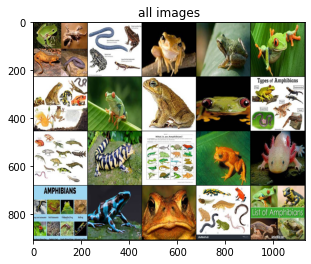

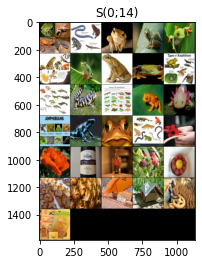

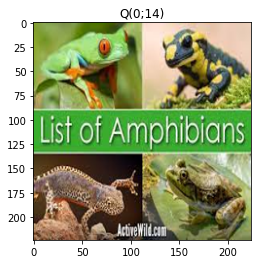

In [ ]:
plot_images(fullSupport, title="all images", images_per_row=N_SHOT)

if showDataClean:
  plot_images(justSupport, title="S("+str(i)+";"+str(j)+")", images_per_row=N_SHOT)
  plot_images(justQuery, title="Q("+str(i)+";"+str(j)+")", images_per_row=1)

In [ ]:
cleaner = Cleaner(PATH_MODEL, modelCleaning, meta_set)
simM = cleaner.cleanSets()

plt.hist(list(itertools.chain(*simM)), bins=20)
plt.xlabel("similarity to queries")
plt.ylabel("number of predictions")
printSimMatrix(simM)

Traning on Set 0: 100%|██████████| 300/300 [34:47<00:00,  6.96s/it]


1        0.02     0.0      0.0      0.99     0.14     0.92     0.36     0.0      0.0      0.23     0.01     0.75     0.0      0.23     0.0      0.0      0.0      0.47     1.0      



Traning on Set 0: 100%|██████████| 300/300 [34:51<00:00,  6.97s/it]


1        0.02     0.0      0.0      0.99     0.14     0.92     0.36     0.0      0.0      0.23     0.01     0.75     0.0      0.23     0.0      0.0      0.0      0.47     1.0      

1.0      1        0.0      0.09     1.0      0.85     1.0      0.9      0.0      0.33     0.99     0.1      0.99     0.39     0.14     0.0      0.18     0.03     0.52     1.0      



Traning on Set 0: 100%|██████████| 300/300 [35:10<00:00,  7.03s/it]


1        0.02     0.0      0.0      0.99     0.14     0.92     0.36     0.0      0.0      0.23     0.01     0.75     0.0      0.23     0.0      0.0      0.0      0.47     1.0      

1.0      1        0.0      0.09     1.0      0.85     1.0      0.9      0.0      0.33     0.99     0.1      0.99     0.39     0.14     0.0      0.18     0.03     0.52     1.0      

0.0      0.0      1        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      



Traning on Set 0:  54%|█████▎    | 161/300 [18:39<16:24,  7.08s/it]

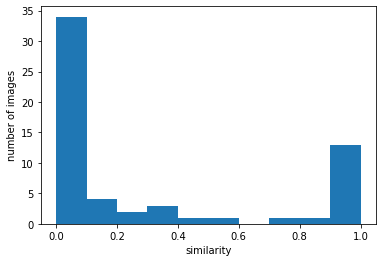

1        0.02     0.0      0.0      0.99     0.14     0.92     0.36     0.0      0.0      0.23     0.01     0.75     0.0      0.23     0.0      0.0      0.0      0.47     1.0      

1.0      1        0.0      0.09     1.0      0.85     1.0      0.9      0.0      0.33     0.99     0.1      0.99     0.39     0.14     0.0      0.18     0.03     0.52     1.0      

0.0      0.0      1        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      



In [ ]:
sM = [
     [1,        0.02,     0.0,      0.0,      0.99,     0.14,     0.92,     0.36,     0.0,      0.0,      0.23,     0.01,     0.75,     0.0,      0.23,     0.0,      0.0,      0.0,      0.47,     1.0],      
     [1.0,      1,        0.0,      0.09,     1.0,      0.85,     1.0,      0.9,      0.0,      0.33,     0.99,     0.1,      0.99,     0.39,     0.14,     0.0,      0.18,     0.03,     0.52,     1.0],      
     [0.0,      0.0,      1,        0.0,      0.0,      0.0,      0.0,      0.0,      0.0,      0.0,      0.0,      0.0,      0.0,      0.0,      0.0,      0.0,      0.0,      0.0,      0.0,      0.0]
     ]
flattenedMatrix = list(itertools.chain(*sM))
plt.hist(flattenedMatrix, bins=10)
plt.xlabel("similarity")
plt.ylabel("number of images")
plt.show()
printSimMatrix(sM)

##--- TRAINING ---

In [ ]:
def getMin(supportClasses):
  """
  because cleaning classes do not have the same number of elements anymore,
  thus there's the need to avoid getting an out of range error
  """
  lenghts = []
  for pathToClass in supportClasses:
    lenghts.append(len(os.listdir(pathToClass)))

  return min(lenghts)

In [ ]:
supportClasses = [PATH_DATA+class_+"/" for class_ in classes]
N_SHOT = getMin(supportClasses)
supportSet, _ = getSets(supportClasses, N_SHOT, 0) 

In [ ]:
print("N_SHOT IS CONFIGURED TO BE", N_SHOT)

N_SHOT IS CONFIGURED TO BE 3


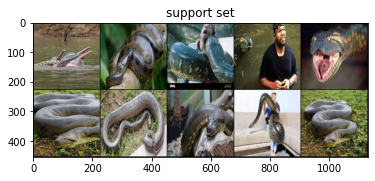

In [ ]:
showDataTrain = True
if showDataTrain:
  justSupport = getOnlyImages(supportSet)
  plot_images(justSupport, title="support set", images_per_row=5)

In [ ]:
training_model = Trainer(PATH_MODEL, model, False)
training_model.training(supportSet, (0, 0), 0)

## --- EVALUATION ---

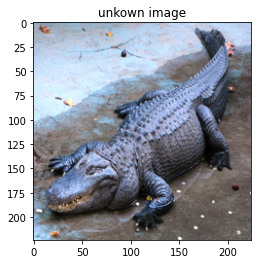

In [ ]:
PATH_TO_UNKNOWN = "/content/drive/MyDrive/Colab Notebooks/pipeline/unkown image/"
queries = os.listdir(PATH_TO_UNKNOWN)
query = getImageTensor(PATH_TO_UNKNOWN+queries[random.randint(0, len(queries)-1)]).unsqueeze(0)
plot_images(query, title="unkown image", images_per_row=1)

In [ ]:
evaluation_model = Tester(training_model.model)
predictedLabel = evaluation_model.queryEvaluation(supportSet, [query])

In [ ]:
print("Image of "+classes[predictedLabel]) # possible error with classes[predictedLabel] to check thourougly

In [ ]:
"""
falseEx = self.getDissimilarImages(meta_set.imageNameSetMatrix[i], preds, self.threshold)
printDistributions(preds, 0.5)
self.printDissimilarImages(Eij[1][0], falseEx)

  def getDissimilarImages(self, pathMatrix, predictionMatrix, e):

    res = []
    for ai, pi in zip(pathMatrix, predictionMatrix):
      if pi < e: 
        res.append(ai)
    
    return res

  def printDissimilarImages(self, Qij, falseEx):

    falseFolder = [Qij]
    for imagePath in falseEx:
      falseFolder.append(getImageTensor(imagePath))

    plot_images(falseFolder, "Query + dissimilar Images", images_per_row=len(falseFolder))
"""